# Omi Ceti: PyMC GP Fitting (periodic)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp
import pandas as pd
import xarray as xr
from pymc.gp.util import plot_gp_dist
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from scipy import signal

RANDOM_SEED = 1
rng = np.random.default_rng(RANDOM_SEED)

#az.style.use("arviz-darkgrid")

# Setting matplotlib fonts
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

print(f"Running on PyMC v{pm.__version__}")

EXECUTE_SAMPLING = False

Running on PyMC v5.1.2


## Data

In [15]:
series_fname = "Omi_Ceti"
#series_raw = pd.read_csv('https://raw.githubusercontent.com/bersavosh/Random/master/rand_files/Omi_Ceti.csv').iloc[-2500:-500:10,]

series_raw = pd.read_csv('https://raw.githubusercontent.com/bersavosh/Random/master/rand_files/Omi_Ceti.csv').iloc[-2500:-500:1,].sample(n=200, random_state=1)

t = series_raw["day"].to_numpy()
y = series_raw["magnitude"].to_numpy()

y_mean = np.mean(y)

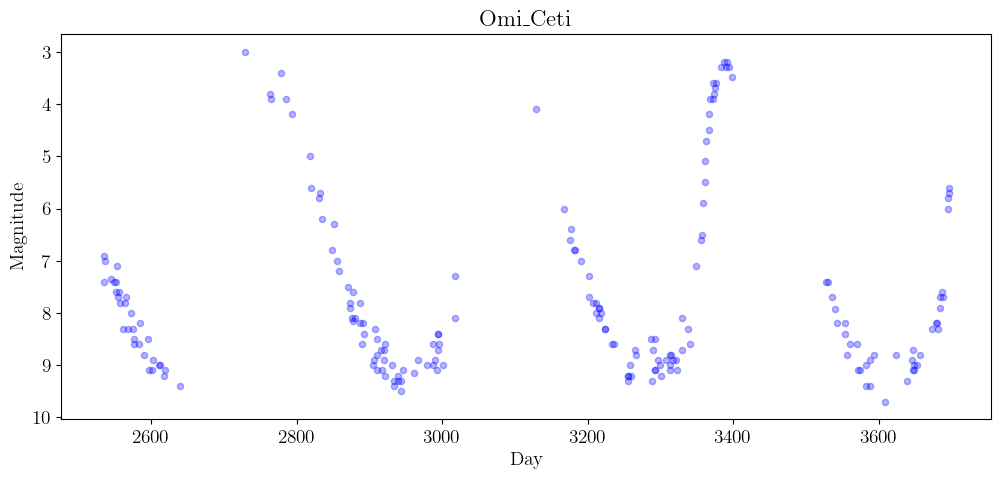

In [43]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

ax.scatter(x=t, y=y, s=20, alpha=0.3, c="b")
ax.invert_yaxis()
ax.set_xlabel("Day")
ax.set_ylabel("Magnitude")
ax.set_title(f"{series_fname}");

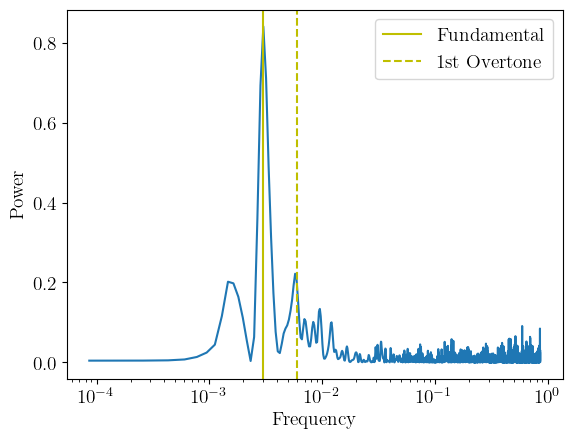

In [17]:
from astropy.timeseries import LombScargle

ls = LombScargle(t, y)
frequency, power = ls.autopower(nyquist_factor=10) 

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.semilogx(frequency, power)
ax.axvline(x=1/332,color='y',linestyle='-',label='Fundamental')
ax.axvline(x=2/332,color='y',linestyle='--',label='1st Overtone')
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.legend();

## Kernel

$$\textrm{Periodic kernel} \qquad k(\tau) = \eta^2 \mathrm{exp}\left\{ -\frac{1}{2}\left[\frac{\sin\left(\pi \frac{\tau}{T}\right)}{\ell}\right]^2 \right\}$$

In [18]:
this_eta = 8
this_T = 400
this_ell = 1
this_cov = this_eta**2 * pm.gp.cov.Periodic(1, period=this_T, ls=this_ell)
this_cov += pm.gp.cov.WhiteNoise(1e-6) # Add white noise to stabilise
this_X = np.linspace(t.min(), t.max(), 1000)[:, None]
this_K = this_cov(this_X).eval()

prior_set = pm.draw(pm.MvNormal.dist(mu=y_mean, cov=this_K, shape=len(this_K)), draws=50, random_seed=rng).T

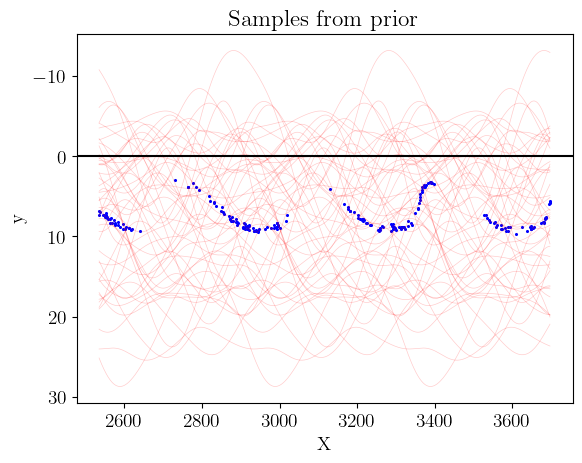

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x=t, y=y, s=1.5, c="b")
ax.plot(this_X, prior_set, lw=0.5, alpha=0.2, color='r')
ax.axhline(0, color="black")
ax.invert_yaxis()
ax.set_title("Samples from prior")
ax.set_xlabel("X")
ax.set_ylabel("y");

In [20]:
with pm.Model() as model:
    # Periodic
    eta = pm.HalfNormal("eta", sigma=8.0)
    ell = pm.Gamma(name="ell", alpha=10, beta=5)
    T = pm.TruncatedNormal(name="T", mu=330, sigma=50, lower=0, upper=1000)
        
    mean_fn = pm.gp.mean.Constant(c = y_mean)
    cov_fn = eta**2 * pm.gp.cov.Periodic(1, period=T, ls=ell) +  pm.gp.cov.WhiteNoise(1e-6)
    
    gp = pm.gp.Marginal(mean_func=mean_fn, cov_func=cov_fn)

    # noise model
    sigma = pm.HalfNormal(name="sigma", sigma=1.0)
    cov_noise = pm.gp.cov.WhiteNoise(sigma)

    # Likelihood
    y_ = gp.marginal_likelihood("y", X=t.reshape(-1,1), y=y.reshape(-1,1).flatten(), sigma=cov_noise)

In [21]:
with model:
    if EXECUTE_SAMPLING:
        idata = pm.sample_prior_predictive(samples=100, random_seed=rng)
    else:
        idata = az.from_netcdf(f"traces/{series_fname}_periodic_idata.nc")

Sampling: [T, ell, eta, sigma, y]


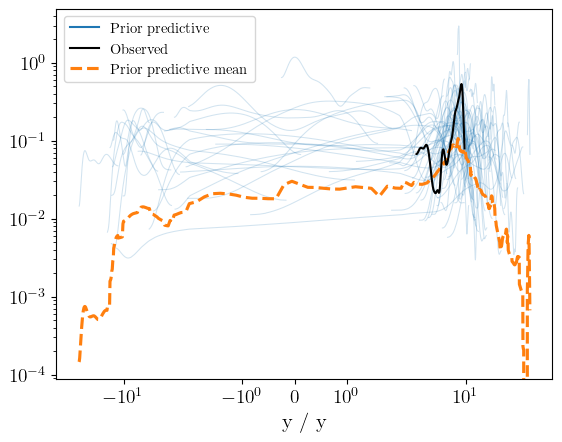

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
az.plot_ppc(idata, group='prior', ax=ax);
ax.set_xscale('symlog')
ax.set_yscale('log');

**NB:** Flux cannot be negative so more contraints can be put on these priors

## Modified PPC

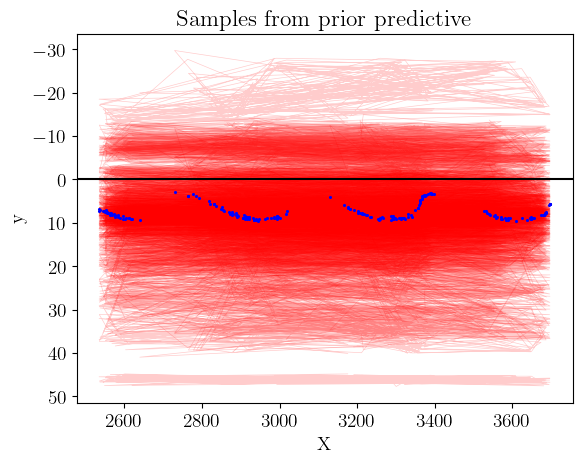

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for prior_pred in idata.prior_predictive.y.to_numpy()[0]:
    ax.plot(t,prior_pred,lw=0.5,alpha=0.2,color='r')

ax.scatter(x=t, y=y, s=1.5, c="b", zorder=10)
ax.invert_yaxis()
ax.axhline(0, color="black")
ax.set_title("Samples from prior predictive")
ax.set_xlabel("X")
ax.set_ylabel("y");

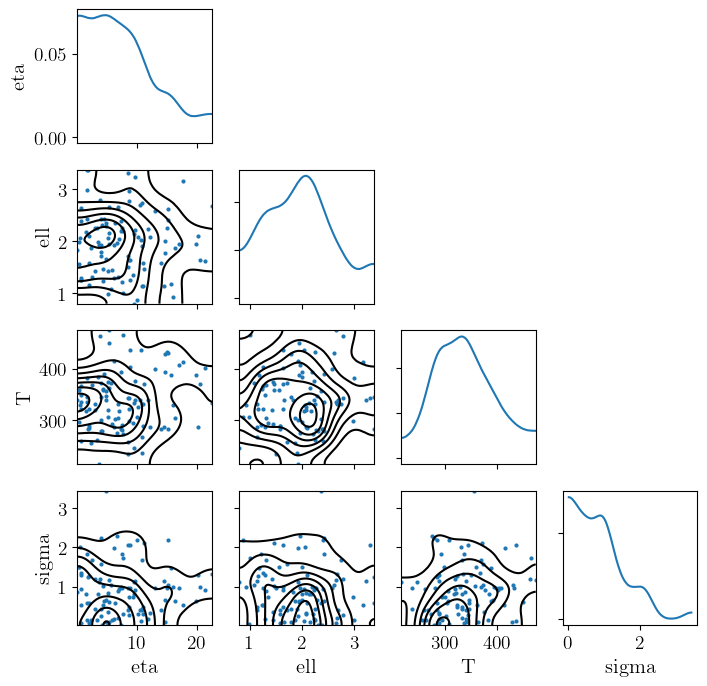

In [24]:
az.plot_pair(idata, group='prior', var_names=['eta', 'ell', 'T', 'sigma'], kind=['scatter','kde'], marginals=True, figsize=(8,8));

In [25]:
with model:
    if EXECUTE_SAMPLING:
        idata.extend(pm.sample(random_seed=rng))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, ell, T, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 208 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [26]:
az.summary(idata, var_names=["eta", "ell", "T", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,3.092,0.958,1.660,4.753,0.019,0.015,3259.0,1994.0,1.01
ell,0.223,0.066,0.147,0.361,0.030,0.022,7.0,30.0,1.52
T,577.210,140.993,332.184,661.513,70.209,53.757,7.0,33.0,1.53
sigma,0.279,0.031,0.236,0.342,0.013,0.010,7.0,30.0,1.52


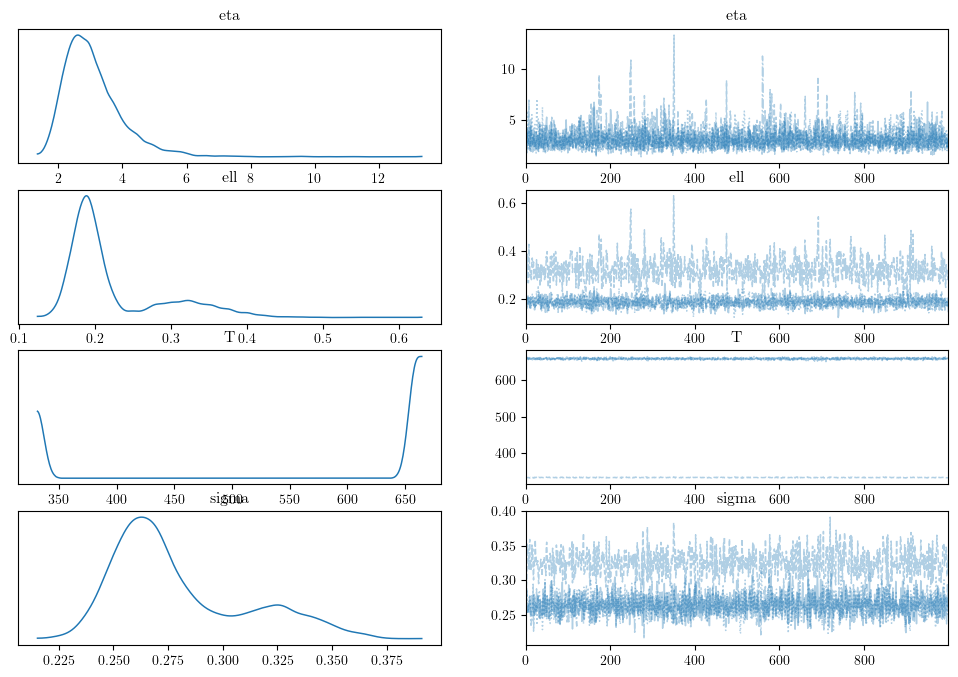

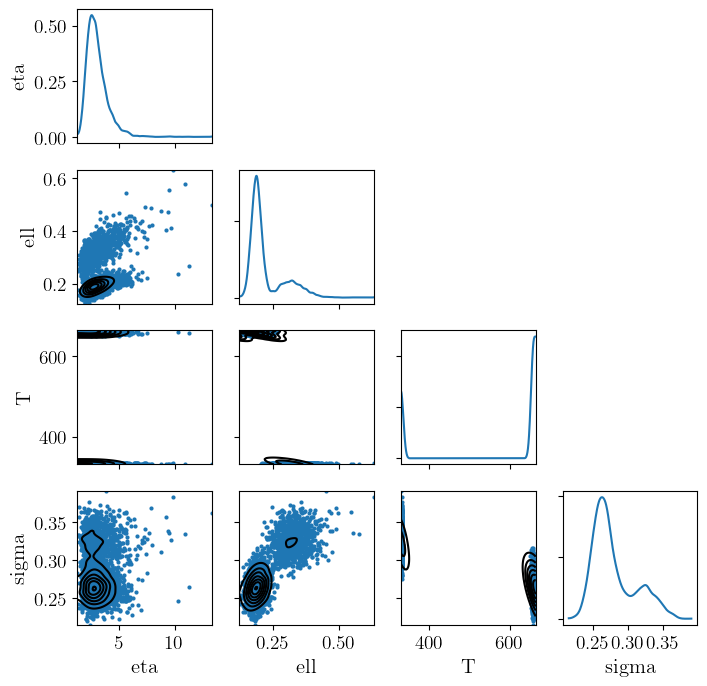

In [27]:
az.plot_trace(idata, combined=True);
az.plot_pair(idata, kind=['scatter','kde'], marginals=True, figsize=(8,8));

In [28]:
RESAMPLE_INTERVAL = 10 # days between samples

t_new = np.linspace(np.floor(t.min()), 
                    np.ceil(t.max()), 
                    num = np.ceil((t.max() - t.min())/RESAMPLE_INTERVAL).astype(int)).reshape(-1,1)

with model:
    if EXECUTE_SAMPLING:
        f_pred = gp.conditional("f_pred", t_new)

In [29]:
with model:
    if EXECUTE_SAMPLING:
        pred_samples = pm.sample_posterior_predictive(idata, var_names=["f_pred"])
        idata.extend(pred_samples)
        az.to_netcdf(idata, f"traces/{series_fname}_periodic_idata.nc")

Sampling: [f_pred]


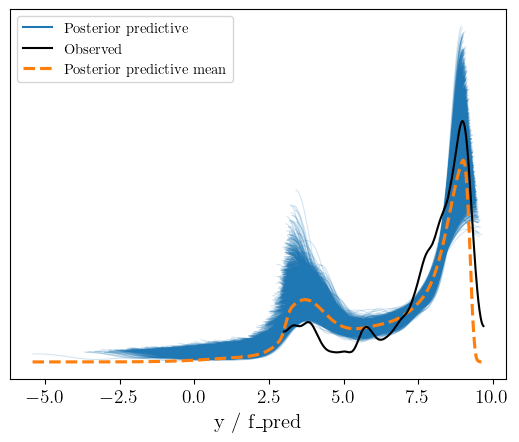

In [30]:
az.plot_ppc(idata, data_pairs={"y":"f_pred"});

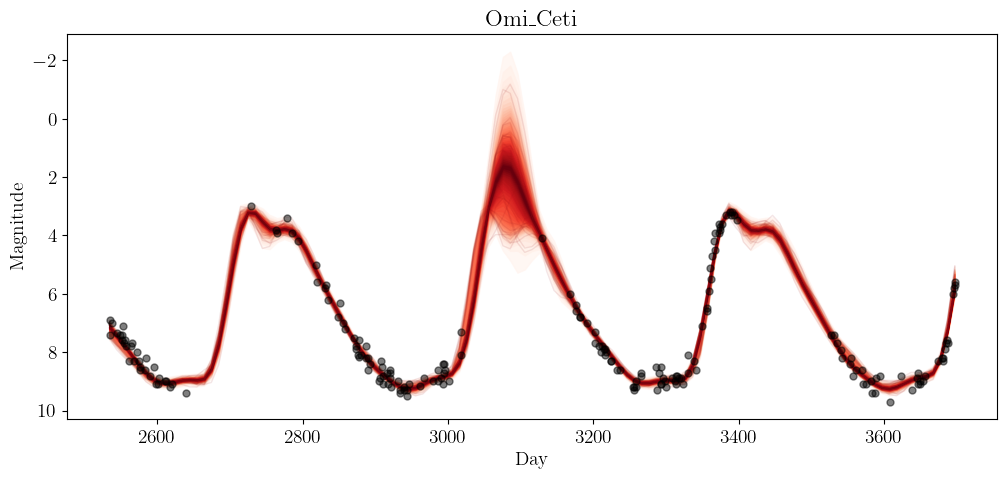

In [37]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.invert_yaxis() 
plot_gp_dist(ax, 
             az.extract(idata.posterior_predictive,
                        var_names=['f_pred']).transpose("sample", ...), 
                        t_new, 
             plot_samples=True)

plt.plot(t, y, "ok", ms=5, alpha=0.5, label="Observed data")
ax.set_xlabel("Day")
ax.set_ylabel("Magnitude")
ax.set_title(f"{series_fname}");

## Power Spectral Density

After testing a few methods, Welch seems to do much better here (FFT-based artefacts null the period in an odd manner). The discussion on what method does best on estimating a PSD runs VERY deep. I did not expect the difference to start being significant in our cases, but apparently, just presence of noise (even white), makes it important. We can look into this further down the track, but it is not a priority as we have a functioning method here.

In [32]:
post_pred = idata.posterior_predictive.f_pred.stack(draws=("chain", "draw"))

xf, welch_psd  = signal.welch(post_pred.to_numpy().T, 
                              fs=1/RESAMPLE_INTERVAL,
                              nfft=2**10,
                              nperseg=2048, detrend=False)

/home/scf/anaconda3/envs/pymc_env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 2048 is greater than input length  = 117, using nperseg = 117
  warnings.warn('nperseg = {0:d} is greater than input length '


/tmp/ipykernel_39804/1885852657.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  fft_q67 = az.hdi(welch_psd, hdi_prob=0.67)
/tmp/ipykernel_39804/1885852657.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  fft_q95 = az.hdi(welch_psd, hdi_prob=0.95)


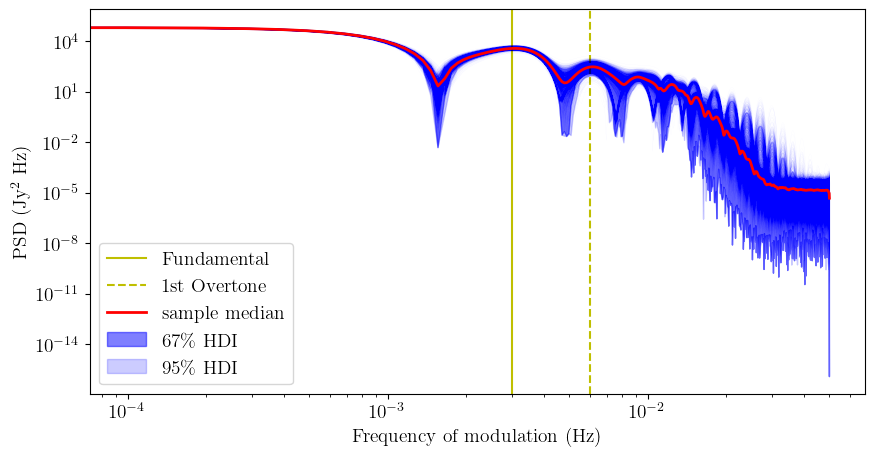

In [45]:
fft_q67 = az.hdi(welch_psd, hdi_prob=0.67)
fft_q95 = az.hdi(welch_psd, hdi_prob=0.95)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.axvline(x=1/332,color='y',linestyle='-',label='Fundamental')
ax.axvline(x=2/332,color='y',linestyle='--',label='1st Overtone')
#ax.plot(xf, welch_psd.T,lw=0.1,color='b',alpha=0.05)
#ax.plot(xf, np.median(welch_psd.T,axis=1),lw=2,color='r', label='sample median')

ax.loglog(xf, welch_psd.T,lw=0.1,color='b',alpha=0.05)
ax.loglog(xf, np.median(welch_psd.T,axis=1),lw=2,color='r', label='sample median')
ax.fill_between(xf, fft_q67.T[0], fft_q67.T[1], alpha=0.5, color='b', label='67\% HDI')
ax.fill_between(xf, fft_q95.T[0], fft_q95.T[1], alpha=0.2, color='b', label='95\% HDI')
ax.set_xlabel('Frequency of modulation (Hz)')
ax.set_ylabel(r'PSD (Jy$^2$ Hz)')
ax.legend();

## Notes:
There are a few points we can chat about in person, I briefly mention them below.

- PSD estimation method: as I alluded to in the PSD section, surprisingly, we are already in a domain that PSD estimation method matters a lot. Welch seems to work well for now (compared to FFT and the weird nulling artefacts it produces). We should proceed with it for now, but perhaps when we are in a more advanced stage, we might look back and asses. We can ask Adrian (Sutinjo) at CIRA, who is an expert on signal processing, for advice on this at that stage. 
- Prior on the period needs more care. We are experiencing a few different effects, which need care:
    - Overtones (harmonics): In a statistical framework, any periodic signal will also manifest as a periodic signal of $\frac{N}{P_F}$ ($P_F$ is the fundamental frequency of the periodicity and $N \in \mathbb{N}$). This is known as harmanic periodicity. You can see this effect in the periodogram as well, as I have denoted it with "1st Harmanic" (corresponding to $2/P_F$). This is not a serious problem, but worth noting that with sparse sampling and noise, we may sometimes run into the issue where a harmonic will appear stronger in PSD than the fundamental. Acoustics folks call this the "missing fundamental" problem. I don't think we have a real solution to this issue (even studies focusing on periodicity searches sometime struggle). However, this is not a problem we are trying to solve. Finding a solution that identifies significant periodisicty (even with degenerate $P$) is all we need.
    - Undertones: Sort of the inverse of the harmonic problem, but acoustics folks don't really run into it because their samples/timeseries are far far larger than the periodicities they deal with. In our case however, we run into the issue where a light curve is only a few times longer than a periodic signal present (or modelled) in the data. This can lead to wide PSD peaks at around $1/(NP_F)$ mixed with and extending to a period comparable to the length of the time series (basically the model says "hey, you have a light curve extending 2000 days? how about a period of 1000 or 2000 days?"). This is also pronounced in our PSD. This, we have some form of approach for a solution: Based on red noise simulations, we can assume ad-hoc thresholds for the prior of a periodic kernel, not allowing it to go beyond a fraction (say, half) of the total timespan covered.